# Data Analyzer

- DataAnalyzer Klasse testen, möglichst so wie sie am Ende aussieht
- Idee: task "analyze" soll später als thread aufgerufen werden können
- laden der Daten soll von einem externen Objekt möglich sein 


In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.ndimage import label, find_objects, median_filter
import lmfit

In [2]:
class ImageAquirer:
    def __init__(self,filepath):
        self.file_path = filepath
        self.index = 1

    def load_im (self):
        filename = self.file_path + str(self.index) + 'test.npy'
        with open(filename, 'rb') as f:
            ar = np.load(f)
        self.index += 1
        ar = ar.reshape(1456, 1936)
        return ar

In [3]:
class Image:
    def __init__(self, image_aquirer):
        self.ia = image_aquirer

        self.data = None
        self.edge = None
        self.update()

    def load_data(self):
        self.data = self.ia.load_im()
    
    def update(self):
        self.load_data()
        self.edge = self.data.shape
        
    def show(self):
        print(self.edge)
        plt.imshow(self.data, cmap='gray')
        plt.show()

In [4]:
class Roi:
    def __init__(self, x_start,x_stop,y_start,y_stop, image):
        self.x_start = x_start
        self.x_stop = x_stop
        self.y_start = y_start
        self.y_stop = y_stop

        self.data = None
        self.edge = None
        self.update(image)

    def load_data(self, image):
        self.data = image.data[(slice(self.y_start, self.y_stop, None), 
                                slice(self.x_start, self.x_stop, None))]
    
    def update(self, image):
        self.load_data(image)
        self.edge = self.data.shape
    
    def change_position_by_user(self,x_start,x_stop,y_start,y_stop):
        pass

    def y_coordinate_in_image(self, y):
        return y + self.y_start
    
    def x_coordinate_in_image(self, x):
        return x + self.x_start

    def show(self):
        print(self.edge)
        plt.imshow(self.data, cmap='gray')
        plt.show()


In [5]:
class FitArea:
    def __init__(self, roi, image, factor, threshold, median=True):
        self.factor = factor
        self.threshold = threshold
        self.median = median

        self.data = None
        self.edge = None
        self.update(roi, image)
    
    def load_data(self, roi, image):
        #median filter
        data = roi.data
        if self.median:
            data = median_filter(data, size=2)

        #threshold filter 
        data = data > self.threshold
        
        #labeln
        data, num_label = label(data)
            #TO DO: check num_label with error

        #fit data frame 
        frame = find_objects(data)
            #TO DO: check if only one object (sonst geht frame[0] nicht)
        y_start, y_stop, x_start, x_stop = frame[0][0].start, frame[0][0].stop, frame[0][1].start, frame[0][1].stop
        dif_x, dif_y = self.calculate_expantion (self.factor, x_start, x_stop, y_start, y_stop)
        frame = self.expand(dif_x, dif_y, 
                            roi.x_coordinate_in_image(x_start), roi.x_coordinate_in_image(x_stop), 
                            roi.y_coordinate_in_image(y_start), roi.y_coordinate_in_image(y_stop), 
                            image.edge[0], image.edge[1])
            #TO DO: check if max werte stimmen
        
        #slice image for
        self.data = image.data[frame]
    
    # factor -> um wie viel mal der Objectgröße erweitern
    def calculate_expantion (self, factor, x_start, x_stop, y_start, y_stop):
        dif_x = int (abs (x_stop - x_start) * factor)
        dif_y = int (abs (y_stop - y_start) * factor)
        return dif_x, dif_y
    
    def expand(self, add_x, add_y, x_start, x_stop, y_start, y_stop, max_x, max_y):
        y_a_neu, y_e_neu = self.expand_partly(add_y,y_start, y_stop, max_y)
        x_a_neu, x_e_neu = self.expand_partly(add_x,x_start, x_stop, max_x)
        return (slice(y_a_neu,y_e_neu, None), slice(x_a_neu, x_e_neu, None))
    
    def expand_partly(self, expantion, start, stop, max, min=0):
        start_new = start - expantion
        stop_new = stop + expantion
        if start_new < min:
            start_new = min
        if stop_new > max:
            stop_new = max
        return start_new, stop_new
    
    def update(self, roi, image):
        self.load_data(roi, image)
        self.edge = self.data.shape

    def change_factor_by_user():
        pass

    def change_threshold_by_user():
        pass

    def change_median_usage_by_user():
        pass

    def show(self):
            print(self.edge)
            plt.imshow(self.data, cmap='gray')
            plt.show()    


In [6]:
class Gaussmodel:
    def __init__(self, fit_area):
        self.z_values_in = fit_area.data.flatten()
        edge_x = fit_area.edge[1]
        edge_y = fit_area.edge[0]
            #TO DO: double check if there is some better syntax
        self.x_values = np.repeat(np.array([range(0,edge_x)]), edge_y, axis=0).flatten()
        self.y_values = np.repeat(np.array([range(edge_y-1, -1, -1)]).reshape(edge_y,1), edge_x, axis=1).flatten()

        self.gauss_model = lmfit.models.Gaussian2dModel()
        self.params = self.gauss_model.guess(self.z_values_in, self.x_values,self.y_values)
        
        self.result = self.gauss_model.fit(self.z_values_in, x=self.x_values, y=self.y_values, params=self.params)
        self.params = self.result.params
        #lmfit.report_fit(self.result)
    
    def update(self, fit_area):
           self.z_values_in = fit_area.data.flatten()
           edge_x = fit_area.edge[0]
           edge_y = fit_area.edge[1]
                #TO DO: double check if there is some better syntax
                #TO DO: check if map values between 0 to 1 is making any difference 
           self.x_values = np.repeat(np.array([range(0,edge_x)]), edge_y, axis=0).flatten()
           self.y_values = np.repeat(np.array([range(edge_y-1, -1, -1)]).reshape(edge_y,1), edge_x, axis=1).flatten()
           
           self.result = self.gauss_model.fit(self.z_values_in, x=self.x_values, y=self.y_values, params=self.params)
           self.params = self.result.params
           #lmfit.report_fit(self.result)

    def get_result(self):
        result = []
        for name, param in self.params.items():
                #TO DO: check if data structur is useful that way
            result.append([name, param.value])
        return result
        
    def show(self):
        fig = plt.figure(figsize=plt.figaspect(0.5))

        #old data
        ax = fig.add_subplot(1, 2, 1, projection='3d')
        ax.set_title("data in")
        ax.scatter(self.x_values, self.y_values, self.z_values_in, c=self.z_values_in, cmap='viridis', linewidth=0.5)

        #fitted data
        z_values_new = self.gauss_model.func(self.x_values, self.y_values, **self.result.best_values)
        ax = fig.add_subplot(1, 2, 2, projection='3d')
        ax.set_title("data fitted")
        ax.scatter(self.x_values, self.y_values, z_values_new, c=z_values_new, cmap='viridis', linewidth=0.5)

        plt.show()

        #fit report
        print("fit")
        lmfit.report_fit(self.result)


## Test

Schritt für Schritt testen Subklassen test

(1456, 1936)


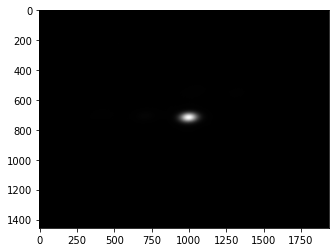

In [7]:
ia = ImageAquirer('D:\\HZB\\Camera_Data\\mls13\\')
im = Image(ia)
im.show()

(300, 450)


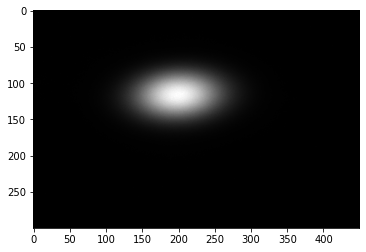

In [8]:
roi = Roi(800, 1250, 600, 900, im)
roi.show()


In [9]:
#min und max werte
print("max",np.amax(roi.data))
print("min",np.amin(roi.data))

max 15373
min 115


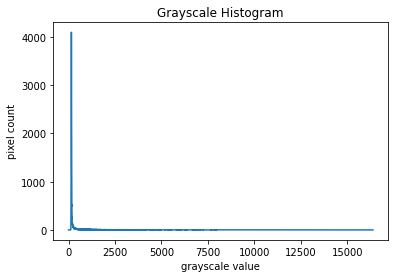

In [10]:
#Histogram
histogram, bin_edges = np.histogram(roi.data, bins=16383, range=(0, 16383))

plt.figure()
plt.title("Grayscale Histogram")
plt.xlabel("grayscale value")
plt.ylabel("pixel count")

plt.plot(bin_edges[0:-1], histogram)  # <- or here
plt.show()

In [11]:
from sklearn.mixture import GaussianMixture

708.7578666666667


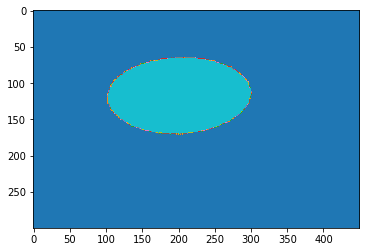

In [12]:
classif = GaussianMixture(n_components=1)
classif.fit(roi.data.reshape((roi.data.size, 1)))

threshold = np.mean(classif.means_)
print(threshold)
med_data = median_filter(roi.data, size=2)
binary_img = med_data > threshold

plt.imshow(binary_img, cmap='tab10')
plt.show()   


1


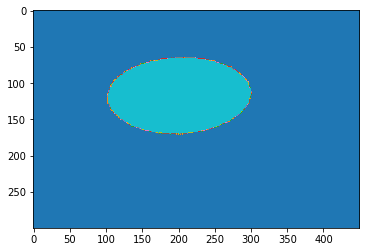

In [13]:
data, num_label = label(binary_img)
print(num_label)
plt.imshow(data, cmap='tab10')
plt.show()

filename = 'labels.npy'
with open(filename, 'wb') as f:
    np.save(f, data)  


(148, 277)


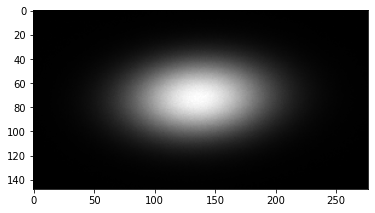

In [14]:
fit_area = FitArea(roi, im, 0.2, 708)
fit_area.show()

filename = '.fit_area.npy'
with open(filename, 'wb') as f:
    np.save(f, fit_area.data)

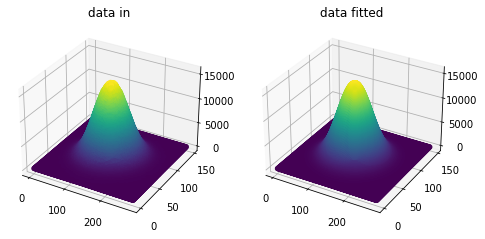

fit
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 50
    # data points      = 40996
    # variables        = 5
    chi-square         = 1.1717e+09
    reduced chi-square = 28584.1057
    Akaike info crit   = 420648.807
    Bayesian info crit = 420691.913
[[Variables]]
    amplitude:  78104037.2 +/- 24228.9888 (0.03%) (init = 1.732537e+07)
    centerx:    136.241181 +/- 0.01204049 (0.01%) (init = 133)
    centery:    74.9279524 +/- 0.00652969 (0.01%) (init = 76)
    sigmax:     38.8154599 +/- 0.01204139 (0.03%) (init = 46)
    sigmay:     21.0499882 +/- 0.00653041 (0.03%) (init = 24.5)
    fwhmx:      91.4034213 +/- 0.02835532 (0.03%) == '2.3548200*sigmax'
    fwhmy:      49.5689331 +/- 0.01537793 (0.03%) == '2.3548200*sigmay'
    height:     150153.950 +/- 46.5791766 (0.03%) == '1.5707963*amplitude/(max(1e-15, sigmax)*max(1e-15, sigmay))'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigmay) =  0.500
    C(amplitude, sigmax) =  0

In [15]:
g_model = Gaussmodel(fit_area)
g_model.show()

zu einer Klasse zusammenführen 

In [16]:
class DataAnalyzer:
    def __init__(self):
        self.ia = ImageAquirer('D:\\HZB\\Camera_Data\\mls13\\')
        self.im = Image(self.ia)
        self.roi = Roi(800, 1250, 600, 900, self.im)
        self.fit_area = FitArea(self.roi, self.im, 0.5, 708)
        self.g_model = Gaussmodel(self.fit_area)
        self.result = g_model.get_result()

    def analyze(self):
        self.im.update()
        self.roi.update(self.im)
        self.fit_area.update(self.roi,self.im)
        self.g_model.update(self.fit_area)
        self.result = g_model.get_result()
    
    def show(self):
        print("im")
        self.im.show()
        print("roi")
        self.roi.show()
        print("fit_area")
        self.fit_area.show()
        print("model")
        self.g_model.show()

im
(1456, 1936)


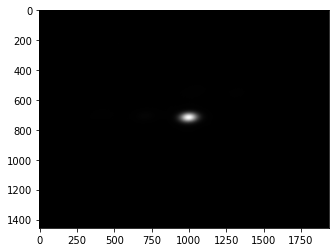

roi
(300, 450)


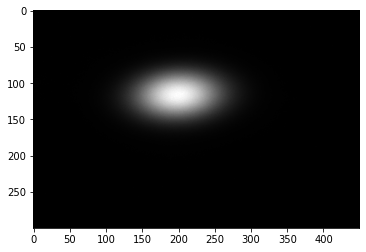

fit_area
(212, 397)


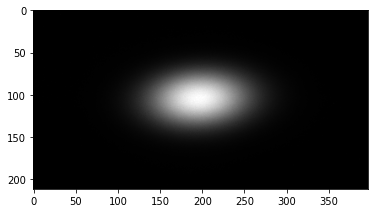

model


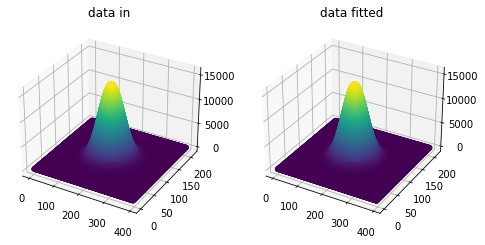

fit
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 43
    # data points      = 84164
    # variables        = 5
    chi-square         = 2.2223e+09
    reduced chi-square = 26405.6107
    Akaike info crit   = 856906.609
    Bayesian info crit = 856953.312
[[Variables]]
    amplitude:  78125045.5 +/- 23291.9493 (0.03%) (init = 3.568073e+07)
    centerx:    196.240947 +/- 0.01157499 (0.01%) (init = 193)
    centery:    106.928217 +/- 0.00627749 (0.01%) (init = 108)
    sigmax:     38.8244377 +/- 0.01157499 (0.03%) (init = 66)
    sigmay:     21.0557247 +/- 0.00627749 (0.03%) (init = 35.16667)
    fwhmx:      91.4245623 +/- 0.02725702 (0.03%) == '2.3548200*sigmax'
    fwhmy:      49.5824417 +/- 0.01478235 (0.03%) == '2.3548200*sigmay'
    height:     150118.696 +/- 44.7559047 (0.03%) == '1.5707963*amplitude/(max(1e-15, sigmax)*max(1e-15, sigmay))'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigmay) =  0.500
    C(amplitude, sigmax)

In [17]:
data_analyzer = DataAnalyzer()
data_analyzer.show()

Testing roi

(216, 397)


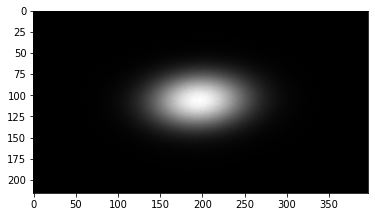

[['amplitude', 78104037.15258864], ['centerx', 136.24118065614402], ['centery', 74.9279523760876], ['sigmax', 38.81545991499899], ['sigmay', 21.049988167054796], ['fwhmx', 91.40342131703792], ['fwhmy', 49.56893313554398], ['height', 150153.94955388556]]
(212, 397)


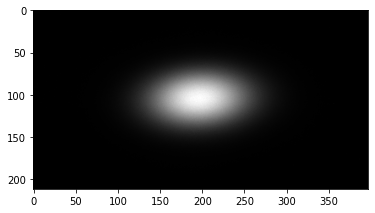

[['amplitude', 78104037.15258864], ['centerx', 136.24118065614402], ['centery', 74.9279523760876], ['sigmax', 38.81545991499899], ['sigmay', 21.049988167054796], ['fwhmx', 91.40342131703792], ['fwhmy', 49.56893313554398], ['height', 150153.94955388556]]
(212, 396)


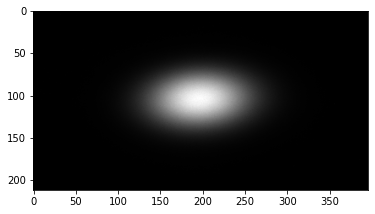

[['amplitude', 78104037.15258864], ['centerx', 136.24118065614402], ['centery', 74.9279523760876], ['sigmax', 38.81545991499899], ['sigmay', 21.049988167054796], ['fwhmx', 91.40342131703792], ['fwhmy', 49.56893313554398], ['height', 150153.94955388556]]
(213, 397)


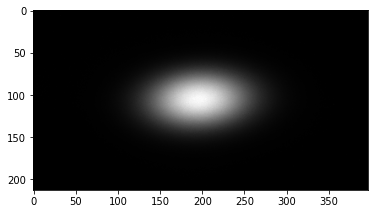

[['amplitude', 78104037.15258864], ['centerx', 136.24118065614402], ['centery', 74.9279523760876], ['sigmax', 38.81545991499899], ['sigmay', 21.049988167054796], ['fwhmx', 91.40342131703792], ['fwhmy', 49.56893313554398], ['height', 150153.94955388556]]
(213, 397)


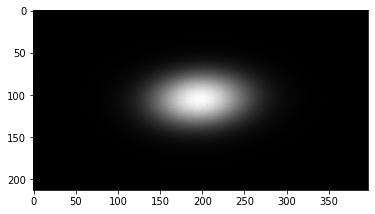

[['amplitude', 78104037.15258864], ['centerx', 136.24118065614402], ['centery', 74.9279523760876], ['sigmax', 38.81545991499899], ['sigmay', 21.049988167054796], ['fwhmx', 91.40342131703792], ['fwhmy', 49.56893313554398], ['height', 150153.94955388556]]
(213, 397)


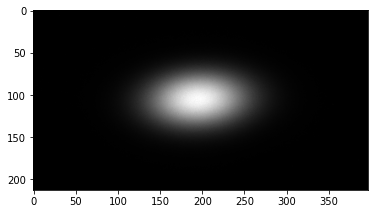

[['amplitude', 78104037.15258864], ['centerx', 136.24118065614402], ['centery', 74.9279523760876], ['sigmax', 38.81545991499899], ['sigmay', 21.049988167054796], ['fwhmx', 91.40342131703792], ['fwhmy', 49.56893313554398], ['height', 150153.94955388556]]
(213, 397)


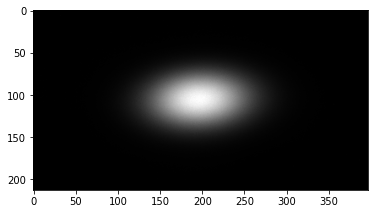

[['amplitude', 78104037.15258864], ['centerx', 136.24118065614402], ['centery', 74.9279523760876], ['sigmax', 38.81545991499899], ['sigmay', 21.049988167054796], ['fwhmx', 91.40342131703792], ['fwhmy', 49.56893313554398], ['height', 150153.94955388556]]
(213, 396)


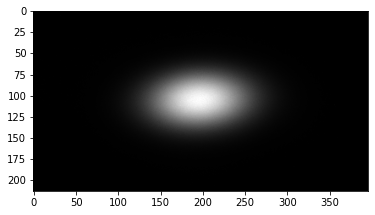

[['amplitude', 78104037.15258864], ['centerx', 136.24118065614402], ['centery', 74.9279523760876], ['sigmax', 38.81545991499899], ['sigmay', 21.049988167054796], ['fwhmx', 91.40342131703792], ['fwhmy', 49.56893313554398], ['height', 150153.94955388556]]
(212, 397)


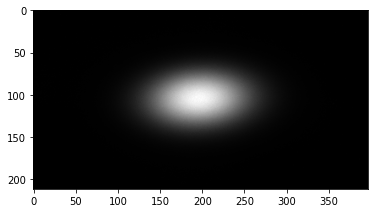

[['amplitude', 78104037.15258864], ['centerx', 136.24118065614402], ['centery', 74.9279523760876], ['sigmax', 38.81545991499899], ['sigmay', 21.049988167054796], ['fwhmx', 91.40342131703792], ['fwhmy', 49.56893313554398], ['height', 150153.94955388556]]
(213, 397)


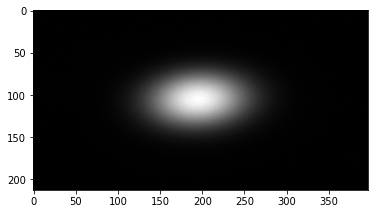

[['amplitude', 78104037.15258864], ['centerx', 136.24118065614402], ['centery', 74.9279523760876], ['sigmax', 38.81545991499899], ['sigmay', 21.049988167054796], ['fwhmx', 91.40342131703792], ['fwhmy', 49.56893313554398], ['height', 150153.94955388556]]


In [18]:
for i in range (0,10):
    data_analyzer.analyze()
    data_analyzer.fit_area.show()
    print(data_analyzer.result)

## Ergebnis

- je mehr datapoints, desto langsamer der Fit 
